In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
ticker = 'AMZN'
start_date = '1997-01-01'
end_date = '2022-11-22'
amz_data = yf.download(ticker, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


In [3]:
amz_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6424 entries, 1997-05-15 to 2022-11-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6424 non-null   float64
 1   High       6424 non-null   float64
 2   Low        6424 non-null   float64
 3   Close      6424 non-null   float64
 4   Adj Close  6424 non-null   float64
 5   Volume     6424 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 351.3 KB


In [4]:
data = amz_data[['Close']]

In [5]:
type(data)

pandas.core.frame.DataFrame

In [6]:
data.describe()

,Close
count,6424.000000
mean,30.696761
std,47.797545
min,0.069792
25%,1.989000
50%,6.238000
75%,36.773874
max,186.570496


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6424 entries, 1997-05-15 to 2022-11-21
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   6424 non-null   float64
dtypes: float64(1)
memory usage: 100.4 KB


<AxesSubplot:xlabel='Date'>

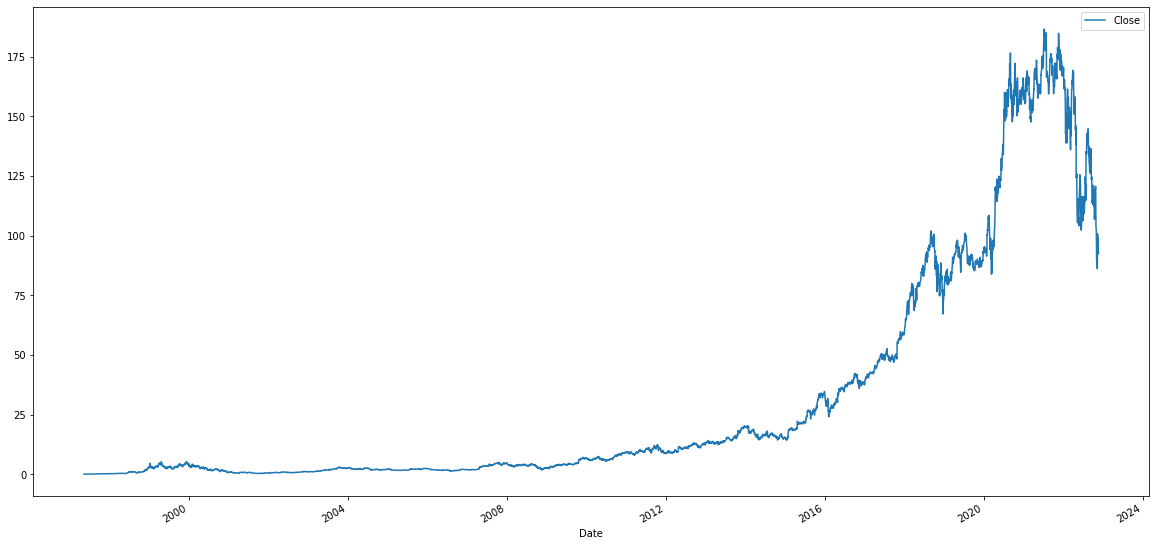

In [8]:
data.plot()

In [9]:
cp_data = data.copy() 

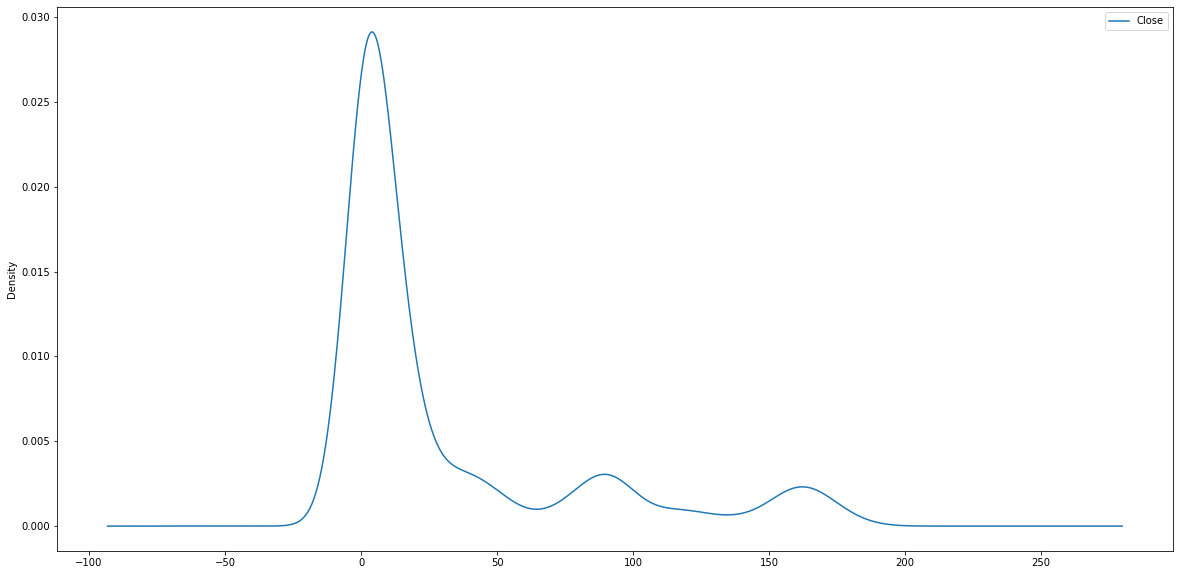

In [10]:
cp_data.plot(kind='kde')
plt.show()

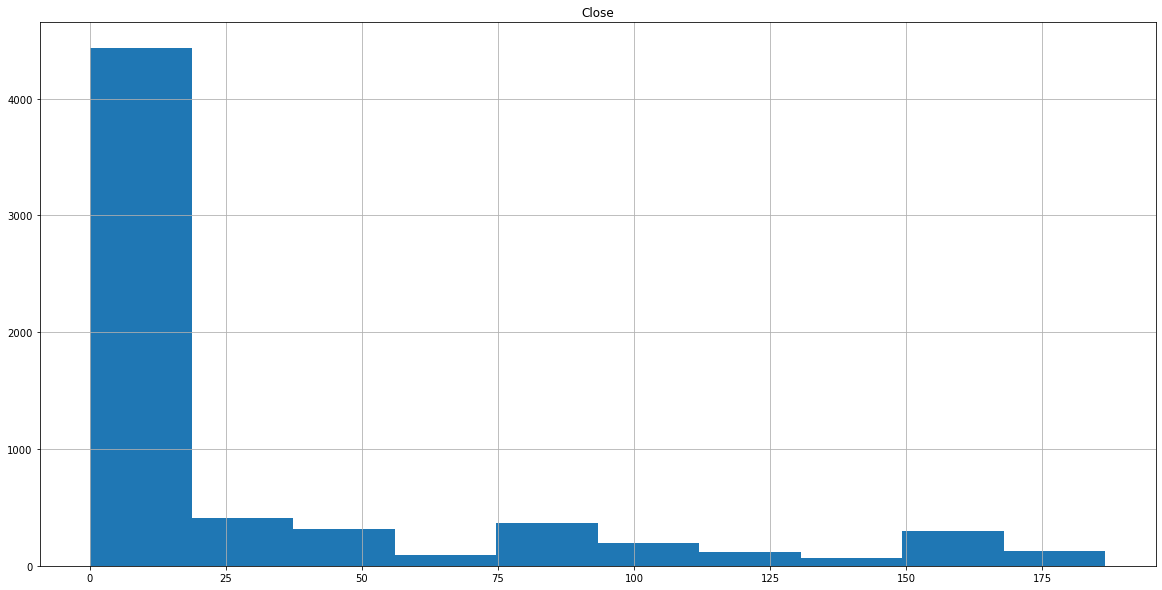

In [11]:
cp_data.hist()
plt.show()

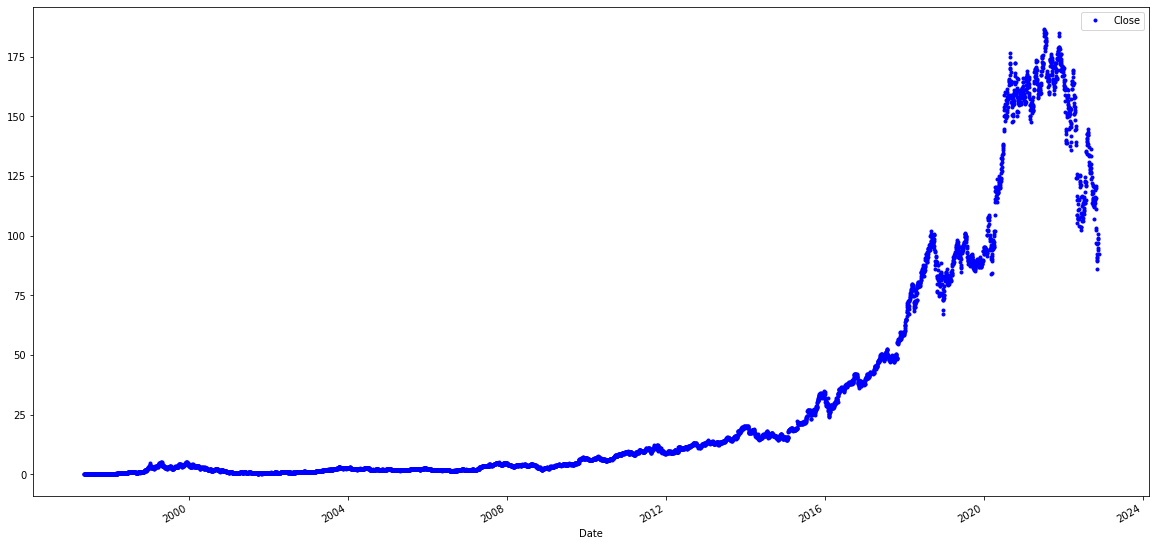

In [12]:
cp_data.plot(style = 'b.')
plt.show()

In [13]:
from pandas.plotting import lag_plot

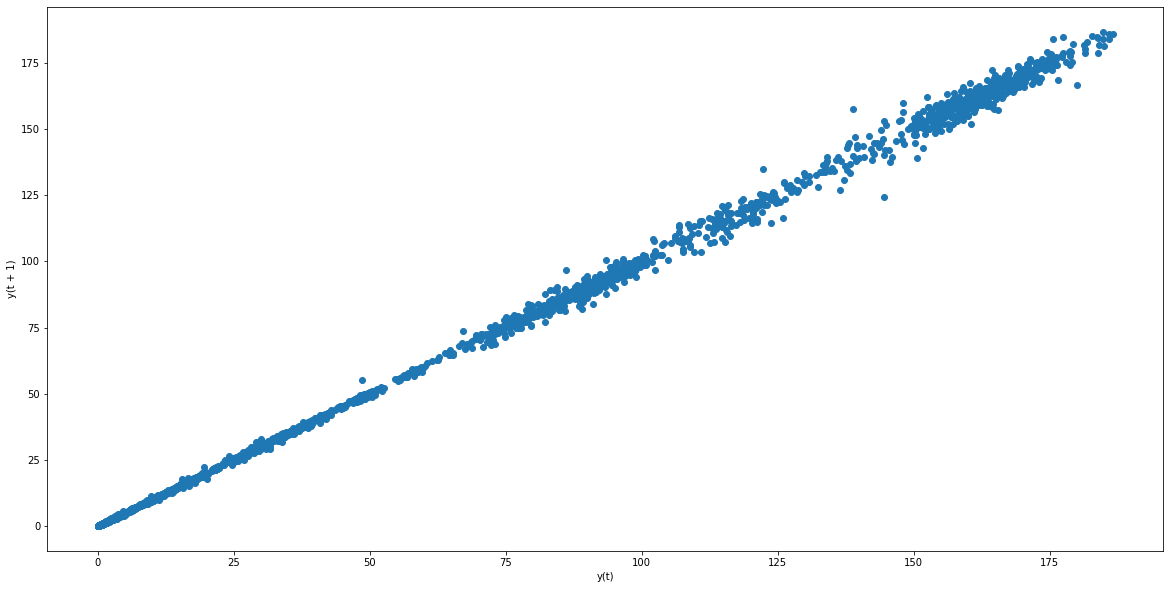

In [14]:
lag_plot(cp_data)
plt.show()

In [15]:
#Exploratory data analysis using ARIMA
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA

In [16]:
#Augmented fuller dickery test to find if data is stationary 
from statsmodels.tsa.stattools import adfuller
result = adfuller(cp_data)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.519665
p-value: 0.888121
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Since the p value is more than 0.05, the null hypothesis will be rejected which means series is non stationary

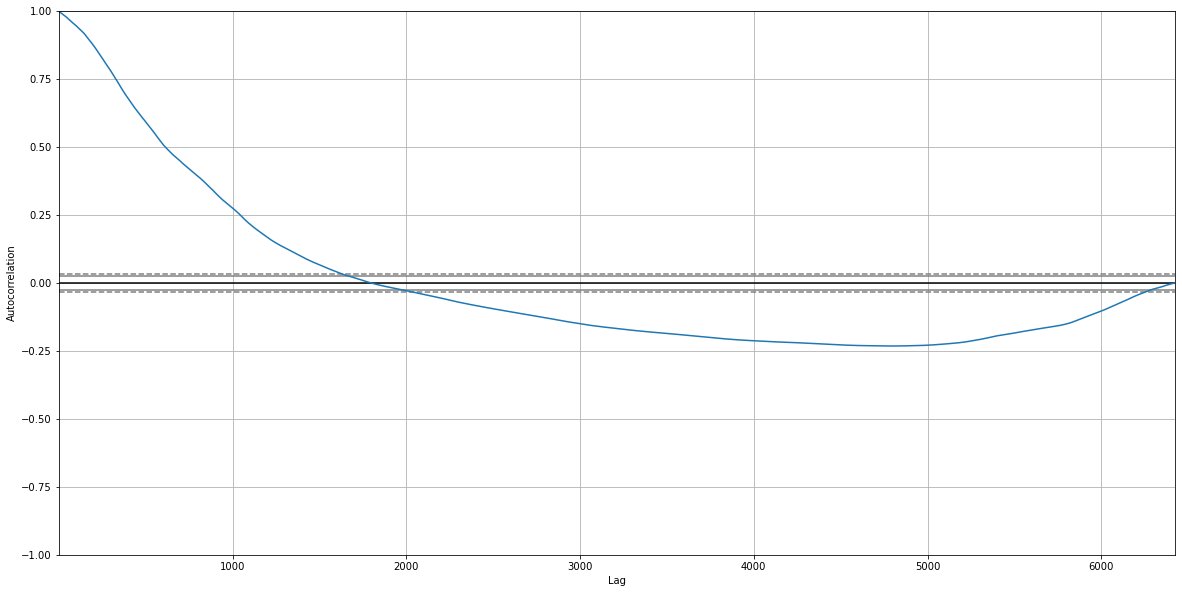

In [17]:
autocorrelation_plot(cp_data['Close'])
plt.show()

In [18]:
scaler=MinMaxScaler(feature_range=(0,1))


In [19]:
size = len(data)
train_data = data[0:int(size*0.8)]
valid_data = data[int(size*0.8):]
scaled_data=scaler.fit_transform(train_data)

In [20]:
x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [21]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

In [22]:
lstm_model.compile(loss='mean_squared_error',optimizer='adam')
history =lstm_model.fit(x_train_data,y_train_data,epochs= 10,batch_size=5,verbose=2)

Epoch 1/10
1016/1016 - 32s - loss: 8.8737e-04 - 32s/epoch - 31ms/step
Epoch 2/10
1016/1016 - 27s - loss: 2.1085e-04 - 27s/epoch - 27ms/step
Epoch 3/10
1016/1016 - 27s - loss: 1.5114e-04 - 27s/epoch - 26ms/step
Epoch 4/10
1016/1016 - 28s - loss: 1.3296e-04 - 28s/epoch - 28ms/step
Epoch 5/10
1016/1016 - 29s - loss: 1.0997e-04 - 29s/epoch - 28ms/step
Epoch 6/10
1016/1016 - 28s - loss: 1.0071e-04 - 28s/epoch - 28ms/step
Epoch 7/10
1016/1016 - 28s - loss: 8.0829e-05 - 28s/epoch - 27ms/step
Epoch 8/10
1016/1016 - 27s - loss: 7.3379e-05 - 27s/epoch - 26ms/step
Epoch 9/10
1016/1016 - 26s - loss: 5.4241e-05 - 26s/epoch - 26ms/step
Epoch 10/10
1016/1016 - 27s - loss: 7.9388e-05 - 27s/epoch - 26ms/step


In [23]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


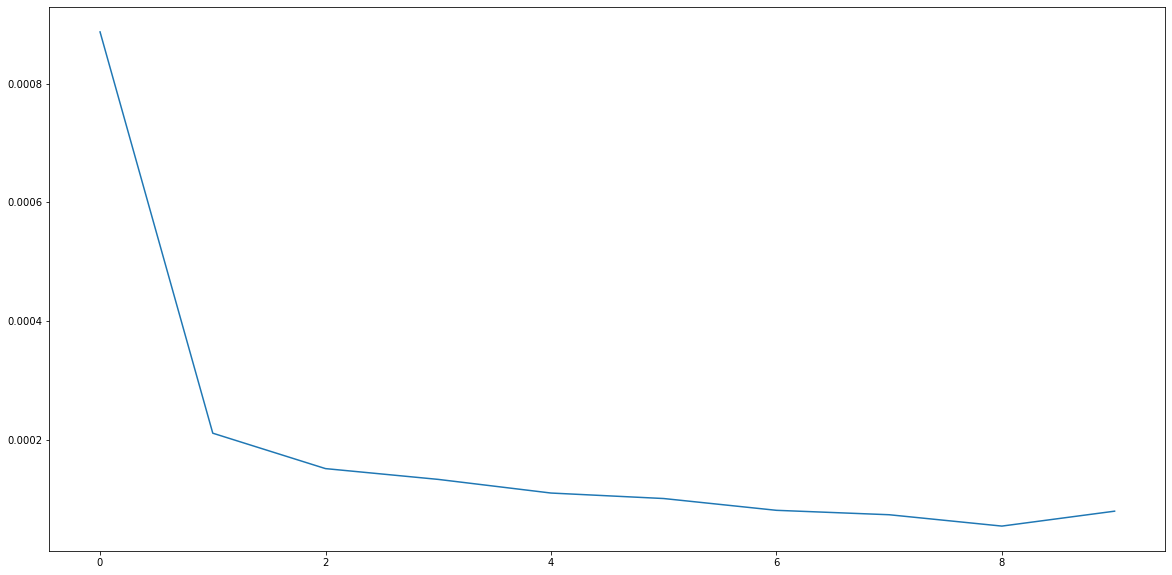

In [24]:
plt.plot(history.history['loss'], label='Training loss')

In [25]:
inputs_data=data[len(data)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)


In [26]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [27]:
closing_price=lstm_model.predict(X_test)
closing_price=scaler.inverse_transform(closing_price)

41/41 [==============================] - 1s 10ms/step


C:\Users\sadar\AppData\Local\Temp/ipykernel_31292/2250828974.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=closing_price


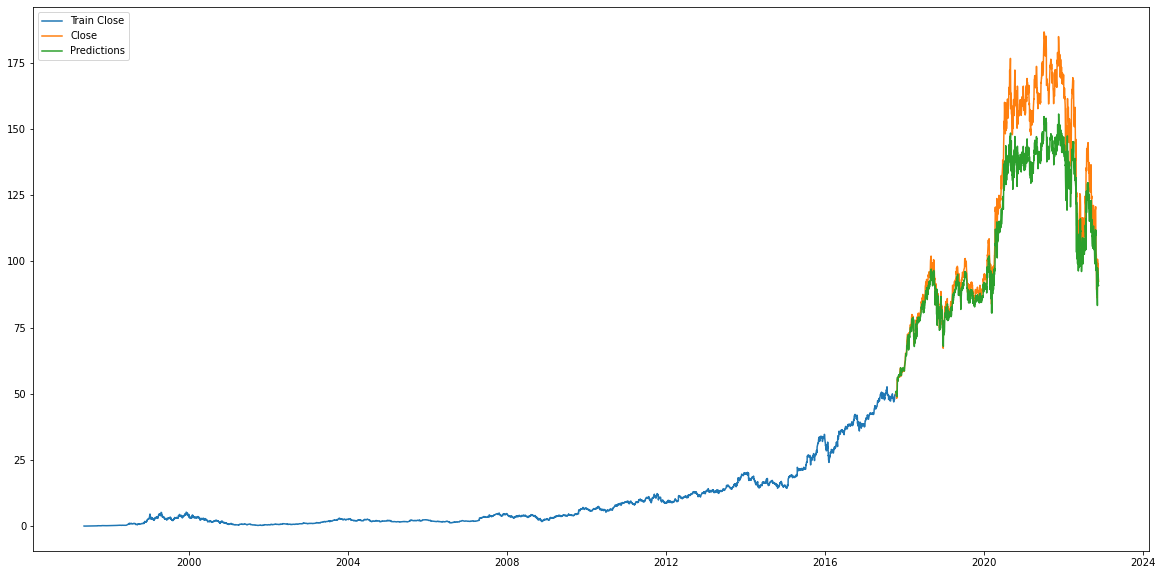

In [28]:
valid_data['Predictions']=closing_price
plt.plot(train_data["Close"], label = 'Train Close')
plt.plot(valid_data[['Close',"Predictions"]], label = ['Close','Predictions'])
plt.legend()

In [29]:
actual,pred =valid_data[['Close',"Predictions"]]

In [30]:
RMSE = mean_squared_error(valid_data['Close'],valid_data['Predictions'],squared=False)
MAPE = mean_absolute_percentage_error(valid_data['Close'],valid_data['Predictions'])
print('RMSE :', RMSE)
print('MAPE :',MAPE)

RMSE : 14.563408340079487
MAPE : 0.07598606150947758


In [31]:
lstm_model.save("saved_lstm_model.h5")